# Airflow Note

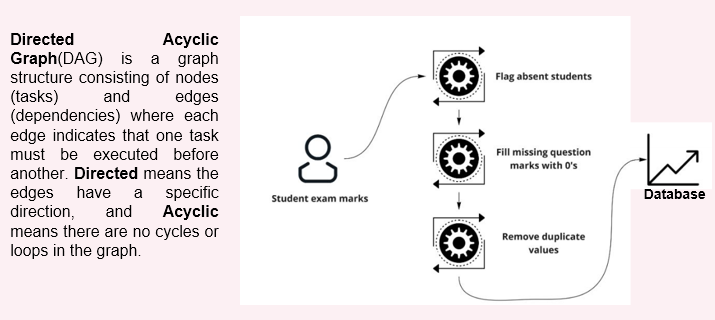

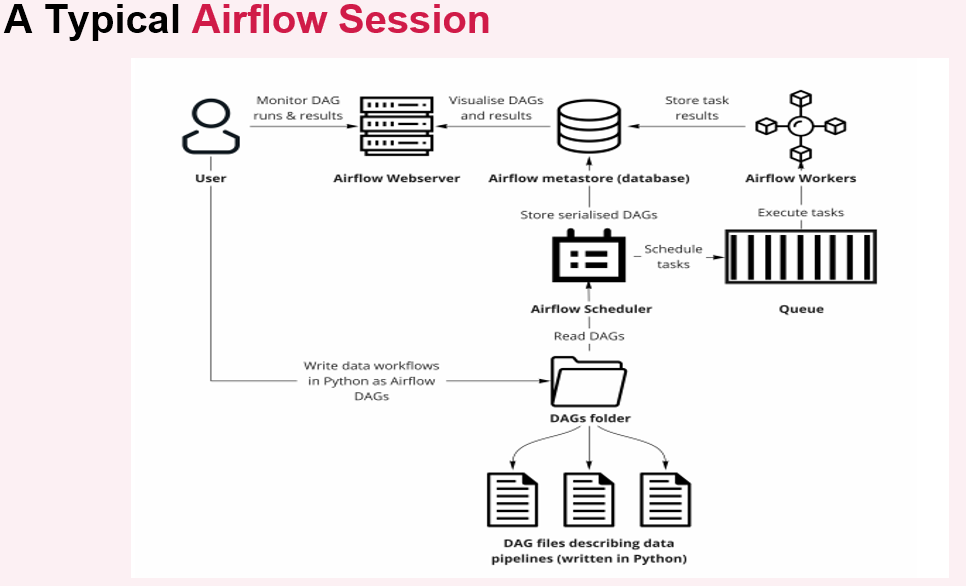

In [8]:
display(Image("algorithm.png"))
display(Image("airflowsession.png")) 

# Case Study : Zipco Foods

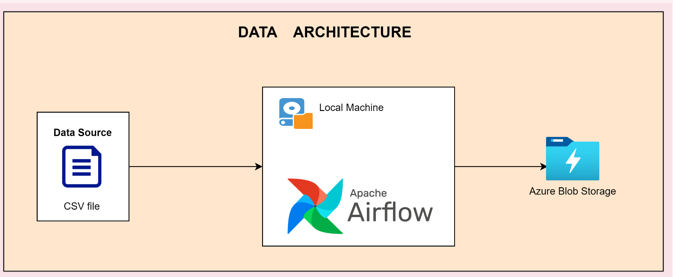

In [ ]:
display(Image("dataarchitecture.png"))    
# DataLink = "https://drive.google.com/file/d/1m-S4FMrblJ6J2dItKRl2h-S9zMyO4u-G/view?usp=drive_link"

In [74]:
import pandas as pd
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from dotenv import load_dotenv
from io import StringIO, BytesIO
import os
from IPython.display import Image, display
import warnings

## Data Extraction

In [48]:

try:
    df = pd.read_csv(r'zipco_transaction.csv')
    print("Data loaded successfully!")
    print(f"Current shape: {df.shape}")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully!
Current shape: (1005, 21)


In [49]:
df.head()

,Date,ProductName,Quantity,UnitPrice,StoreLocation,PaymentType,PromotionApplied,Weather,Temperature,StaffPerformanceRating,...,DeliveryTime_min,OrderType,CustomerName,CustomerAddress,Customer_PhoneNumber,CustomerEmail,Staff_Name,Staff_Email,DayOfWeek,TotalSales
0,2023-01-01 00:00:00,Vanilla Cake,2,12.532304,South,Cash,True,Rainy,20.654914,Poor,...,30,In Store,William Adams,"9851 David Green\r\nTonyaburgh, VA 02853",(916)427-7276x861,lisa00@example.net,John Bridges,pdavidson@example.com,Sunday,25.064608
1,2023-01-01 01:00:00,Red Velvet Cake,1,7.083070,South,Cash,False,Rainy,23.549497,Average,...,33,In Store,Anthony Wiggins,"24682 Holly Stravenue\r\nMooreville, NH 13901",769.318.4373,michellefernandez@example.com,Sarah Bentley,ajohnson@example.net,Sunday,7.083070
2,2023-01-01 02:00:00,Chocolate Cake,5,6.736064,North,Cash,True,Rainy,NaN,Excellent,...,43,Phone Order,Ashley Duke,10184 Washington Trace Apt. 679\r\nEast Brandi...,702.520.3286,cooperwilliam@example.com,Connie Cervantes,michele29@example.net,Sunday,33.680321
3,2023-01-01 03:00:00,Carrot Cake,2,7.314823,North,Cash,False,Cloudy,20.137483,Poor,...,32,Online Order,Brandon Taylor,"87194 Jeff Rue\r\nMitchellbury, CA 50463",622-527-9530,fsilva@example.net,Jessica Stewart,xwilson@example.org,Sunday,14.629647
4,2023-01-01 04:00:00,Pizza Pepperoni,1,7.577727,East,Credit Card,True,Cloudy,23.020987,Good,...,58,In Store,Brittany Watkins,"850 Julia Groves\r\nHartview, WI 95954",759-517-8359,petersjoseph@example.net,Cheryl Carpenter,christine96@example.org,Sunday,7.577727


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    1005 non-null   object 
 1   ProductName             1005 non-null   object 
 2   Quantity                1005 non-null   int64  
 3   UnitPrice               1005 non-null   float64
 4   StoreLocation           1005 non-null   object 
 5   PaymentType             1005 non-null   object 
 6   PromotionApplied        1005 non-null   bool   
 7   Weather                 1005 non-null   object 
 8   Temperature             904 non-null    float64
 9   StaffPerformanceRating  1005 non-null   object 
 10  CustomerFeedback        905 non-null    object 
 11  DeliveryTime_min        1005 non-null   int64  
 12  OrderType               1005 non-null   object 
 13  CustomerName            1005 non-null   object 
 14  CustomerAddress         1005 non-null   

## Data cleaning and transformation

In [56]:
# Remove duplicates
# Drop duplicate rows from the DataFrame
data = df.copy()
print(f"Initial shape: {data.shape}")
print("Removing duplicates...")
data.drop_duplicates(inplace=True)
print(f" Duplicates removed. Current shape: {data.shape}")


Initial shape: (1005, 21)
Removing duplicates...
 Duplicates removed. Current shape: (1000, 21)


In [62]:
# Convert object columns that look like dates to datetime
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

    for col in data.select_dtypes(include='object').columns:
        try:
            converted = pd.to_datetime(data[col], errors='raise')
            if converted.notna().sum() > 0:
                data[col] = converted
                print(f"✅ Converted '{col}' to datetime.")
        except Exception:
            pass  # Skip columns that can't be converted


✅ Converted 'Date' to datetime.


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1000 non-null   datetime64[ns]
 1   ProductName             1000 non-null   object        
 2   Quantity                1000 non-null   int64         
 3   UnitPrice               1000 non-null   float64       
 4   StoreLocation           1000 non-null   object        
 5   PaymentType             1000 non-null   object        
 6   PromotionApplied        1000 non-null   bool          
 7   Weather                 1000 non-null   object        
 8   Temperature             900 non-null    float64       
 9   StaffPerformanceRating  1000 non-null   object        
 10  CustomerFeedback        900 non-null    object        
 11  DeliveryTime_min        1000 non-null   int64         
 12  OrderType               1000 non-null   object        

In [64]:
# Handling missing values (Example: fill missing numeric values with the mean or median)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    #data[col].fillna(data[col].mean(), inplace=True)
    mean_value = data[col].mean()
    data.fillna({col: data[col].mean()}, inplace=True)
    print(f" Filled missing values in '{col}' with mean: {mean_value:.2f}")

print(" All numeric missing values filled.")

 Filled missing values in 'Quantity' with mean: 3.04
 Filled missing values in 'UnitPrice' with mean: 12.65
 Filled missing values in 'Temperature' with mean: 27.15
 Filled missing values in 'DeliveryTime_min' with mean: 37.74
 Filled missing values in 'TotalSales' with mean: 38.36
 All numeric missing values filled.


In [65]:
# Handling missing values (Example: fill missing string values with 'Unknown')
string_columns = data.select_dtypes(include=['object']).columns
for col in string_columns:
    #data[col].fillna('Unknown', inplace=True)
    data.fillna({col: 'Unknown'}, inplace=True)
    print(f" Filled missing values in '{col}' with unknown")
print(" All string missing values filled.")

 Filled missing values in 'ProductName' with unknown
 Filled missing values in 'StoreLocation' with unknown
 Filled missing values in 'PaymentType' with unknown
 Filled missing values in 'Weather' with unknown
 Filled missing values in 'StaffPerformanceRating' with unknown
 Filled missing values in 'CustomerFeedback' with unknown
 Filled missing values in 'OrderType' with unknown
 Filled missing values in 'CustomerName' with unknown
 Filled missing values in 'CustomerAddress' with unknown
 Filled missing values in 'Customer_PhoneNumber' with unknown
 Filled missing values in 'CustomerEmail' with unknown
 Filled missing values in 'Staff_Name' with unknown
 Filled missing values in 'Staff_Email' with unknown
 Filled missing values in 'DayOfWeek' with unknown
 All string missing values filled.


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1000 non-null   datetime64[ns]
 1   ProductName             1000 non-null   object        
 2   Quantity                1000 non-null   int64         
 3   UnitPrice               1000 non-null   float64       
 4   StoreLocation           1000 non-null   object        
 5   PaymentType             1000 non-null   object        
 6   PromotionApplied        1000 non-null   bool          
 7   Weather                 1000 non-null   object        
 8   Temperature             1000 non-null   float64       
 9   StaffPerformanceRating  1000 non-null   object        
 10  CustomerFeedback        1000 non-null   object        
 11  DeliveryTime_min        1000 non-null   int64         
 12  OrderType               1000 non-null   object        

In [67]:
# Create Products Table
products = data[['ProductName', 'UnitPrice']].drop_duplicates().reset_index(drop=True)
products.index.name = 'ProductID'
products = products.reset_index()
products.head()

,ProductID,ProductName,UnitPrice
0,0,Vanilla Cake,12.532304
1,1,Red Velvet Cake,7.083070
2,2,Chocolate Cake,6.736064
3,3,Carrot Cake,7.314823
4,4,Pizza Pepperoni,7.577727


In [68]:
# Create Customers Table
customers = data[['CustomerName', 'CustomerAddress', 'Customer_PhoneNumber', 'CustomerEmail']].drop_duplicates().reset_index(drop=True)
customers.index.name = 'CustomerID'
customers = customers.reset_index()
customers.head()  

,CustomerID,CustomerName,CustomerAddress,Customer_PhoneNumber,CustomerEmail
0,0,William Adams,"9851 David Green\r\nTonyaburgh, VA 02853",(916)427-7276x861,lisa00@example.net
1,1,Anthony Wiggins,"24682 Holly Stravenue\r\nMooreville, NH 13901",769.318.4373,michellefernandez@example.com
2,2,Ashley Duke,10184 Washington Trace Apt. 679\r\nEast Brandi...,702.520.3286,cooperwilliam@example.com
3,3,Brandon Taylor,"87194 Jeff Rue\r\nMitchellbury, CA 50463",622-527-9530,fsilva@example.net
4,4,Brittany Watkins,"850 Julia Groves\r\nHartview, WI 95954",759-517-8359,petersjoseph@example.net


In [69]:
# Create Staff Table
staff = data[['Staff_Name', 'Staff_Email']].drop_duplicates().reset_index(drop=True)
staff.index.name = 'StaffID'
staff = staff.reset_index()
staff.head()

,StaffID,Staff_Name,Staff_Email
0,0,John Bridges,pdavidson@example.com
1,1,Sarah Bentley,ajohnson@example.net
2,2,Connie Cervantes,michele29@example.net
3,3,Jessica Stewart,xwilson@example.org
4,4,Cheryl Carpenter,christine96@example.org


In [70]:
# Create Transaction Table
transactions = data.merge(products, on = ['ProductName', 'UnitPrice'], how='left') \
                   .merge(customers, on = ['CustomerName', 'CustomerAddress', 'Customer_PhoneNumber', 'CustomerEmail'], how='left') \
                   .merge(staff, on= ['Staff_Name', 'Staff_Email'], how='left')
transactions.index.name = 'TransactionID'
transactions = transactions.reset_index() \
                           [['TransactionID', 'Date', 'ProductID', 'CustomerID', 'StaffID', 'Quantity', 'StoreLocation', 'PaymentType', \
                                'PromotionApplied', 'Weather', 'Temperature', 'StaffPerformanceRating', 'CustomerFeedback', \
                                'DeliveryTime_min', 'OrderType', 'DayOfWeek', 'TotalSales']]

In [71]:
transactions.head()

,TransactionID,Date,ProductID,CustomerID,StaffID,Quantity,StoreLocation,PaymentType,PromotionApplied,Weather,Temperature,StaffPerformanceRating,CustomerFeedback,DeliveryTime_min,OrderType,DayOfWeek,TotalSales
0,0,2023-01-01 00:00:00,0,0,0,2,South,Cash,True,Rainy,20.654914,Poor,Neutral,30,In Store,Sunday,25.064608
1,1,2023-01-01 01:00:00,1,1,1,1,South,Cash,False,Rainy,23.549497,Average,Positive,33,In Store,Sunday,7.083070
2,2,2023-01-01 02:00:00,2,2,2,5,North,Cash,True,Rainy,27.154342,Excellent,Unknown,43,Phone Order,Sunday,33.680321
3,3,2023-01-01 03:00:00,3,3,3,2,North,Cash,False,Cloudy,20.137483,Poor,Positive,32,Online Order,Sunday,14.629647
4,4,2023-01-01 04:00:00,4,4,4,1,East,Credit Card,True,Cloudy,23.020987,Good,Neutral,58,In Store,Sunday,7.577727


## Data Loading: Save normalized tables to azure container

In [1]:
from datetime import timedelta
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago

AirflowConfigException: Cannot use relative path: `sqlite:///C:\Users\Probook/airflow/airflow.db` to connect to sqlite. Please use absolute path such as `sqlite:////tmp/airflow.db`.

--Save normalized tables to new CSV files
data.to_csv('data/clean_data.csv', index=False)
products.to_csv('data/products.csv', index=False)
customers.to_csv('data/customers.csv', index=False)
staff.to_csv('data/staff.csv', index=False)
transactions.to_csv('data/transactions.csv', index=False)

In [81]:
# Azure connection string and container name
load_dotenv()
connect_str = os.getenv('ZIPCO_AZURE_STORAGE_CONNECTION_STRING')
container_name = os.getenv('zipco_container_name')

# Create a BlobServiceClient object
blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client(container_name)

In [ ]:
# Dictionary of DataFrames
dfs = {
     "cleaned_data": data,
      "products": products,
      "customers": customers,
      "staff": staff,
      "transactions": transactions
}

In [82]:
# Upload Multiple DataFrames as CSVs In-Memory
for name, df in dfs.items():
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=f"{name}.csv")
    blob_client.upload_blob(csv_buffer.getvalue(), overwrite=True)
    print(f" Uploaded {name}.csv into Azure Blob Storage")

 Uploaded cleaned_data.csv into Azure Blob Storage
 Uploaded products.csv into Azure Blob Storage
 Uploaded customers.csv into Azure Blob Storage
 Uploaded staff.csv into Azure Blob Storage
 Uploaded transactions.csv into Azure Blob Storage


In [80]:
# Alternative: Upload Multiple DataFrames as Parquet Files In-Memory
for name, df in dfs.items():
    buffer = BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=f"{name}.parquet")
    blob_client.upload_blob(buffer, overwrite=True)
    print(f" Uploaded {name}.parquet into Azure Blob Storage")

 Uploaded cleaned_data.parquet into Azure Blob Storage
 Uploaded products.parquet into Azure Blob Storage
 Uploaded customers.parquet into Azure Blob Storage
 Uploaded staff.parquet into Azure Blob Storage
 Uploaded transactions.parquet into Azure Blob Storage
